<a href="https://colab.research.google.com/github/aovolkov/bitcoin_price_prediction/blob/main/notebooks/lstm_bitcoin_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler, StandardScaler

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Датасет содержит данные цены (включая цену открытия, закрытия, самую высокую и низкую) за период с 31.12.2011 по 14.09.2020 c биржи _Bitstamp_.

## Первичное преобразование данных

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_btc_day = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projects/Bitcoin_price/bitcoin_price_day.csv')
data_btc_month = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projects/Bitcoin_price/bitcoin_price_month.csv')

In [4]:
data_btc_day.shape

(3178, 10)

In [5]:
data_btc_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3178 entries, 0 to 3177
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   DateTime           3178 non-null   object 
 1   Open               3178 non-null   float64
 2   High               3178 non-null   float64
 3   Low                3178 non-null   float64
 4   Close              3178 non-null   float64
 5   Volume_(BTC)       3178 non-null   float64
 6   Volume_(Currency)  3178 non-null   float64
 7   Weighted_Price     3178 non-null   float64
 8   Date               3178 non-null   object 
 9   Time               3178 non-null   object 
dtypes: float64(7), object(3)
memory usage: 248.4+ KB


In [6]:
data_btc_day['DateTime'] = pd.to_datetime(data_btc_day['DateTime'])
data_btc_day.set_index('DateTime', inplace=True)
data_price_day = data_btc_day['Weighted_Price']
data_price_day.head()

DateTime
2011-12-31 17:00:00    4.580000
2012-01-01 22:45:00    5.000000
2012-01-02 20:04:00    5.000000
2012-01-03 17:27:00    5.290000
2012-01-04 17:51:00    5.442972
Name: Weighted_Price, dtype: float64

Функция скользящего окна.

In [7]:
def sliding_window(data, window_length):
    xs = []
    ys = []

    for i in range(len(data)-window_length-1):
        x_i = data[i:(i+window_length)]
        y_i = data[i+window_length]
        xs.append(x_i)
        ys.append(y_i)

    xs = np.array(xs)
    ys = np.array(ys)
    xs_var = Variable(torch.from_numpy(xs).float())
    ys_var = Variable(torch.from_numpy(ys).float())
    return xs_var, ys_var

Отмасштабируем данные

In [8]:
sc = MinMaxScaler()
training_data = sc.fit_transform(data_price_day.values.reshape((-1,1)))

Тренировочный и тестовый датасеты.

In [9]:
window_length = 20
X_data, y_data = sliding_window(training_data, window_length) 

train_size = int(len(y_data) * 0.75)
test_size = len(y_data) - train_size

X_train = X_data[0:train_size]
y_train = y_data[0:train_size]

X_test = X_data[train_size:len(X_data)]
y_test = y_data[train_size:len(y_data)]

## LSTM Model



In [10]:
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        output, (h_t, с_t) = self.lstm(x, (h_0, c_0))
        h_t = h_t.view(-1, self.hidden_size)
        out = self.fc(h_t)
        return out

In [11]:
# история значений ошибок
history_loss = []

# параметры модели
input_size = 1
hidden_size = 20
num_layers = 1

model = LSTM(input_size, hidden_size, num_layers)

# функция ошибки
criterion = torch.nn.MSELoss()

# оптимизатор
optimizer = torch.optim.Adam(model.parameters())

Обучение модели

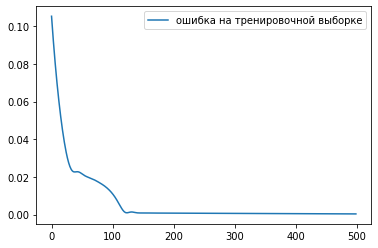

In [12]:
NUM_EPOCHS = 500

for epoch in range(NUM_EPOCHS):
    
    outputs = model(X_train)
    optimizer.zero_grad()
    
    # считаем loss
    loss = criterion(outputs, y_train)
    
    loss.backward()
    
    optimizer.step()

    history_loss.append(loss.data.numpy())

    if (epoch+1) % 10 == 0:
            clear_output(True)
            plt.plot(history_loss, label='ошибка на тренировочной выборке')
            plt.legend()
            plt.show()
        
assert np.mean(history_loss[:10]) > np.mean(history_loss[-10:]), "Модель не сходится"

Визуализация результатов

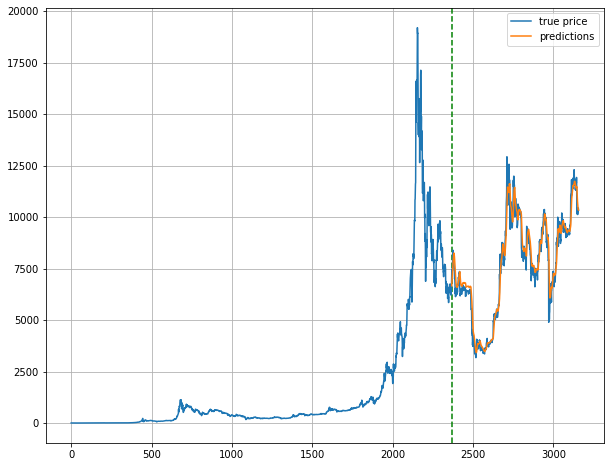

In [13]:
model.eval()
train_predict = model(X_test)

data_predict = train_predict.data.numpy()
data_predict = sc.inverse_transform(data_predict)
data_predict = np.concatenate((np.array([np.nan] * train_size), data_predict), axis=None)

y_data_pl = y_data.data.numpy()
y_data_pl = sc.inverse_transform(y_data_pl)

plt.figure(figsize=(10,8))
plt.axvline(x=train_size, c='g', linestyle='--')
plt.plot(y_data_pl, label='true price')
plt.plot(data_predict, label='predictions')
plt.grid()
plt.legend()
plt.show()

## Выводы

1) Видно, что результаты прогнозов получаются достаточно правдоподобными. Ошибка заметно меньше, чем в модели ARIMA.

2) Обучение здесь длилось гораздо быстрее, чем тот же самый подбор параметров в ARIMA. 